# Time Series Analysis for Parcel data

First import the necessary utilities to conduct the analysis

In [ ]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

from core import (
    normality_test,
    plot_sequence,
    add_date_to_data,
    plot_sequence_with_date,
    forecast_multiplicative_trend_and_seasonal,
    compute_descriptive_statistics,
    zero_mean_test,
    constant_variance_test,
    forecast_additive_seasonal,
    randomness_test,
    compute_autocorrelation,
    forecast_simple,
)

Read the data from the `.sav` file. The path of the file will change dependening
on whether the code is run locally or from Jupyter Book

In [ ]:
base_path = Path.cwd() if Path("data").exists() else Path.cwd().parent.parent
data_path = base_path / "data/Parcel sin tiempo.sav"

raw_data = pd.read_spss(data_path)

To understand the nature of the data, a sequence plot could be used.

In [ ]:
plot_sequence(raw_data.parcel, "Parcel Time Series");

Since this is daily data, it is useful to add extra columns to represent dates
in the x-axis. This will correspond to a longitudinal study with one observation
per day. As a convention the first day is a Sunday. Three new columns are added,
one for the date, one for the day and another one for the week.

In [ ]:
data_with_dates = add_date_to_data(raw_data)
data_with_dates.head()

Plotting the data againwith this new information on the x-axis

In [ ]:
plot_sequence_with_date(
    data_with_dates, "parcel", "date", "Parcel Time Series with Dates"
);

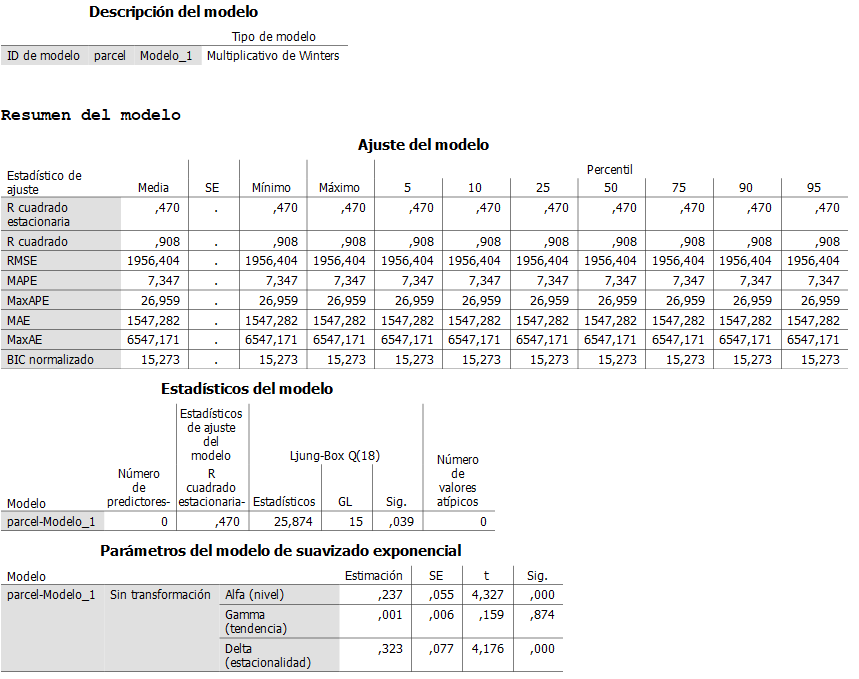

Upon visual inspection, it is assumed that the model has a trend and
seasonality, moreover, it is assumed to have increasing variance, therefore a
trend and seasonal multiplicative model is used.

In [ ]:
fit_model = forecast_multiplicative_trend_and_seasonal(
    data_with_dates, "parcel", "date", 7
)
print(f"RMSE: {fit_model.rmse:.3f}")
print(f"R^2: {fit_model.r_squared:.3g}")

Now predictions are generated using this model and added as a new `forecast`
column.

In [ ]:
predictions = fit_model.predict(0, len(data_with_dates) - 1)
data_with_forecast = data_with_dates.assign(forecast=predictions.values)
data_with_forecast.head()

A plot is done with the observations against the predictions for the same time
period to determine if there is good fit.

In [ ]:
ax = plt.subplot()
plot_sequence_with_date(
    data_with_forecast,
    "parcel",
    "date",
    "Parcel Time Series with Dates",
    ax=ax,
    label="Measured",
)
plot_sequence_with_date(
    data_with_forecast,
    "forecast",
    "date",
    "Parcel Time Series with Dates",
    ax=ax,
    ls="--",
    label="Forecast",
)
plt.legend();

The fit is not clear and it seems good at times but inaccurate on other times. A
more analytical approach can be taken by inspecting the confidence intervals for
the different model parameters as well as the model summary.

In [ ]:
for parameter in fit_model.parameters:
    print(parameter)
print()

print(fit_model.summary)

It was identified that the trend parameter CI includes zero and thus is not statistically significant. Therefore a different model should be used without a trend component.

In [ ]:
fit_model = forecast_additive_seasonal(data_with_dates, "parcel", "date", 7)
print(f"RMSE: {fit_model.rmse:.3f}")
print(f"R^2: {fit_model.r_squared:.3g}")

In [ ]:
predictions = fit_model.predict(0, len(data_with_dates) - 1)
data_with_forecast_and_residuals = data_with_dates.assign(
    forecast=predictions.values,
    residuals=fit_model.residuals,
)
data_with_forecast_and_residuals.head()

In [ ]:
ax = plt.subplot()
plot_sequence_with_date(
    data_with_forecast_and_residuals,
    "parcel",
    "date",
    "Parcel Time Series with Dates",
    ax=ax,
    label="Measured",
)
plot_sequence_with_date(
    data_with_forecast_and_residuals,
    "forecast",
    "date",
    "Parcel Time Series with Dates",
    ax=ax,
    ls="--",
    label="Forecast",
)
plt.legend();

Visually this model fits the data better than the previous, an analytical check
must be done as well to validate the parameters are statistically significant.

In [ ]:
for parameter in fit_model.parameters:
    print(parameter)

print()

print(fit_model.summary)

P-values are all below the significance level, meaning that the null hypothesis
of the parameters being zero can be rejected with 95% confidence.

However it is also important to inspect the residuals generated by this model
and validate if they follow the model's assumptions.

# Model Assumptions

1. The residuals should be normally distributed.
2. The residuals should have zero mean.
3. The residuals should have constant variance (homoscedasticity).
4. The residuals should be independent.
5. The residuals should be random

Before proceeding with the corresponding tests, having a look at the descriptive
statistics of the residuals could shed some light on what to expect.

In [ ]:
SIGNIFICANCE = 0.05
residuals = data_with_forecast_and_residuals["residuals"]
descriptive_stats = compute_descriptive_statistics(residuals)
descriptive_stats.show()

## Test for normality

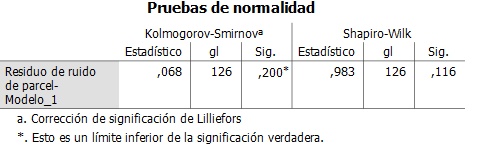

The normality assumption states that the residuals should follow a normal
distribution. However the parameters of that normal distribution are unknown. In
this case and for big (N>50) sample sizes, the Kolmogorov-Smirnov test could be
used, with the Lilliefors correction.

It is also possible to use a visual tool like a histogram with a kernel density
function, but interpretation could be misleading as the number of bins and its
width could yield different conclusion. Conducting hypothesis testing provides a
more objective measure. A similar argument could be done for the Q-Q Plot. Both
of which are presented below as well as the critical statistic and the p-values

For more information see {cite:ps}`lilliefors1967kolmogorov`

In [ ]:
normality_test(residuals, significance_level=SIGNIFICANCE)

## Test for means Zero

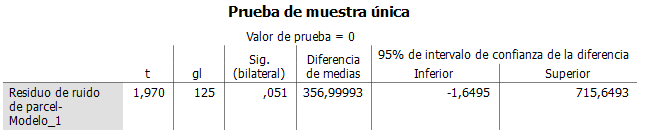

The residuals should have a zero mean, a typical t-Student test for one sample
could be used for this. If the population standard deviation is known and the
sample size is big enough, a Z-test could have been used instead. Since the
population standard deviation is unknown, a t-test is used.

For more information see {cite:ps}`student1908probable`

In [ ]:
zero_mean_test(
    residuals,
    descriptive_stats,
    degrees_of_freedom=fit_model.degrees_of_freedom,
    significance_level=SIGNIFICANCE,
)

The null hypothesis could not be rejected. It is important to know that this could be just statistical luck and with a ever so slightly larger sample size {cite:ps}`cohen1994earth` this hypothesis could be easly rejected. One must be aware of the cherry picking fallacy.

## Test for constant variance

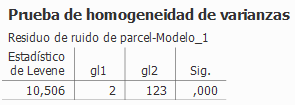

To assess that the variance is constant, the Levene test could be used. This
test is for multiple samples so one could divide the sample in thirds and then
apply the test to them. For more information see {cite:ps}`levene1960robust`

Another test that could be used to detect hetorescedasticity is {cite:ps}`breusch1979simple`

In [ ]:
constant_variance_test(residuals, significance_level=SIGNIFICANCE)

## Test for Independence

To prevent the residuals to exibit dependence with previous values, an
autocorrelation plot could be used. This plot should the values for different
lags. 

For more information see {cite:ps}`box1970time` and {cite:ps}`granger2001essentials`

In [ ]:
compute_autocorrelation(residuals)

## Test for randomness

Finally it is important to ensure that the sample comes from a random process
and has no underlying pattern. Here the Wald test could be used.

For more information see {cite:ps}`wald1940test`

In [ ]:
randomness_test(residuals)

## Conclusion

From the previously descrived assumptions, one is not met:

1. ✅ The residuals should be normally distributed.
2. ✅ The residuals should have zero mean.
3. ❌The residuals should have constant variance (homoscedasticity).
4. ✅ The residuals should be independent.
5. ✅ The residuals should be random

# Mitigating Heteroskedasticity 

To mitigate this violation, a transformation can be applied to the data prior to training a model. One possible transformation is a running average.

For more information see {cite:ps}`hamilton1994time`

In [ ]:
data_with_moving_average = data_with_dates.assign(
    rolling_parcel=lambda df: df["parcel"].rolling(window=5).mean()
).dropna()
data_with_moving_average

A model with an additive behaviour over the seasonality is used.

In [ ]:
fit_model = forecast_additive_seasonal(
    data_with_moving_average, "rolling_parcel", "date", 7
)
print(f"RMSE: {fit_model.rmse:.3f}")
print(f"R^2: {fit_model.r_squared:.3g}")

for parameter in fit_model.parameters:
    print(parameter)

print()

print(fit_model.summary)

The model fitting experienced errors, suggesting it is not a good fit. A simpler
model without seasonality could be used instead.

In [ ]:
fit_model = forecast_simple(data_with_moving_average, "rolling_parcel", "date", 7)
print(f"RMSE: {fit_model.rmse:.3f}")
print(f"R^2: {fit_model.r_squared:.3g}")

for parameter in fit_model.parameters:
    print(parameter)

print()

print(fit_model.summary)

Here all the parameters are statistically significant and no errors are detected.

In [ ]:
predictions = fit_model.predict(0, len(data_with_moving_average) - 1)
data_with_moving_average_forecast_and_residuals = data_with_moving_average.assign(
    forecast=predictions.values, residuals=fit_model.residuals
)
data_with_moving_average_forecast_and_residuals.head()

In [ ]:
ax = plt.subplot()
plot_sequence_with_date(
    data_with_moving_average_forecast_and_residuals,
    "rolling_parcel",
    "date",
    "Parcel Time Series with Dates",
    ax=ax,
    label="Measured",
)
plot_sequence_with_date(
    data_with_moving_average_forecast_and_residuals,
    "forecast",
    "date",
    "Parcel Time Series with Dates",
    ax=ax,
    ls="--",
    label="Forecast",
)
plt.legend();

In [ ]:
SIGNIFICANCE = 0.05
moving_average_residuals = data_with_moving_average_forecast_and_residuals["residuals"]
moving_average_descriptive_stats = compute_descriptive_statistics(
    moving_average_residuals
)
moving_average_descriptive_stats.show()

## Test for normality

![image.png](attachment:image.png)

In [ ]:
normality_test(moving_average_residuals, significance_level=SIGNIFICANCE)

## Test for means Zero

![image.png](attachment:image.png)

In [ ]:
zero_mean_test(
    moving_average_residuals,
    moving_average_descriptive_stats,
    degrees_of_freedom=fit_model.degrees_of_freedom,
    significance_level=SIGNIFICANCE,
)

## Test for constant variance

![image.png](attachment:image.png)

In [ ]:
# constant_variance_test(moving_average_residuals, significance_level=significance)

## Test for Independence

In [ ]:
compute_autocorrelation(moving_average_residuals)

## Test for randomness

In [ ]:
randomness_test(moving_average_residuals)

```{bibliography}
:style: plain
```